In [5]:

import zipfile
import os

# Unzip using zipfile
with zipfile.ZipFile('fundamental-research-project.zip', 'r') as zip_ref:
    zip_ref.extractall('.')


In [6]:
import shutil

shutil.rmtree('fundamental-research-project')

In [1]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
from typing import List
from tabulate import tabulate
from dataclasses import dataclass, field
import matplotlib.pyplot as plt

# Trainer
from src.trainer.trainer import Trainer

#
from src.models.p4_allcnn import P4AllCNNC
from src.models.chA_p4_cnn import A_Ch_P4CNN
from src.models.spA_p4_cnn import A_Sp_P4CNN
from src.models.fA_p4_allcnn import fA_P4AllCNNC
from src.models.big_cnn import B15_P4CNN, B11_P4CNN

## rot-MNIST dataset

In [2]:
from torchvision.datasets import GTSRB
from torch.utils.data import Subset
from torchvision import transforms
import torch

# ----- Transform -----
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# ----- Load full train/test sets -----
full_train_set = GTSRB(root='data', split='train', download=True, transform=transform)
full_test_set = GTSRB(root='data', split='test', download=True, transform=transform)

# ----- Filter to first 10 classes -----
def filter_classes(dataset, allowed_labels):
    indices = [i for i, (_, label) in enumerate(dataset) if label in allowed_labels]
    return Subset(dataset, indices)

allowed_labels = list(range(10))
train_set = filter_classes(full_train_set, allowed_labels)
test_set = filter_classes(full_test_set, allowed_labels)

# Split train/val
train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)


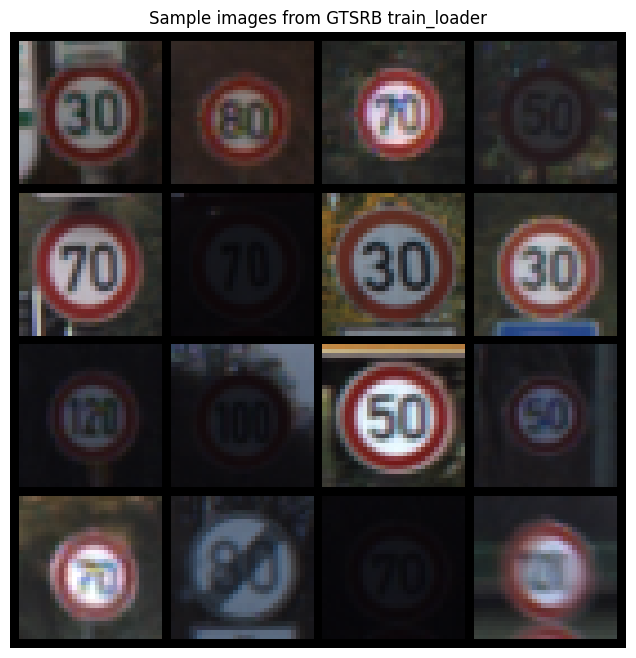

Labels: [1, 5, 4, 2, 4, 4, 1, 1, 8, 7, 2, 2, 4, 6, 4, 8]


In [3]:
import matplotlib.pyplot as plt
import torchvision

dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images[:16], nrow=4, padding=2)
npimg = img_grid.numpy()

plt.figure(figsize=(8, 8))
plt.imshow(np.transpose(npimg, (1, 2, 0)))  # CHW -> HWC
plt.title("Sample images from GTSRB train_loader")
plt.axis('off')
plt.show()

print("Labels:", labels[:16].tolist())


## Experiment

In [8]:
# ----- Helper Functions -----
def init_model(name):
    if name == "p4_allcnn":
        return P4AllCNNC()
    elif name == "fA_p4_allcnn":
        return fA_P4AllCNNC()
    else:
        raise ValueError(f"Unknown model name: {name}")

def init_optimizer(model, lr, weight_decay):
    return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

def init_scheduler(optimizer, milestones):
    return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 250, 300], gamma=0.1)

# ----- Helper Classes -----
@dataclass
class HyperParams:
    lr: float
    epochs: int
    weight_decay: float
    momentum: float
    gamma: float
    milestones: List[int] = field(default_factory=list)

In [15]:
# ----- Configuration -----
num_iterations = 3
log_dir = "../logs"

model_hyperparameters = {
    "p4_allcnn":  HyperParams(lr=0.01, epochs=100, weight_decay=1e-3, momentum=0.9, milestones=[200, 250, 300], gamma=0.1),
    "fA_p4_allcnn": HyperParams(lr=0.01, epochs=100, weight_decay=1e-3, momentum=0.9, milestones=[200, 250, 300], gamma=0.1)
}
model_names = model_hyperparameters.keys()
accuracies = {name: [] for name in model_names}

In [16]:
# ----- Main Training Loop -----


for it in range(num_iterations):
    print(f"Iteration {it + 1}/{num_iterations}")

    for name in model_names:
        print(f"\n→ Training model: {name}")

        # 1. Grab hyperparams for this model
        hp = model_hyperparameters[name]

        # 2. Initialize model, criterion, optimizer, scheduler
        model = init_model(name)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(
            model.parameters(),
            lr=hp.lr,
            momentum=hp.momentum,
            weight_decay=hp.weight_decay
        )
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=hp.milestones,
            gamma=hp.gamma
        )

        # 3. Wrap in our Trainer (single‐model)
        trainer = Trainer(
            models={name: model},
            optimizers=[optimizer],
            criterions=[criterion],
            schedulers=[scheduler],
            log_dir=f"{log_dir}/{name}"
        )

        # 4. Train & validate with the model‐specific epoch count
        trainer.train(
            num_epochs=hp.epochs,
            train_loader=train_loader,
            val_loader=val_loader,
        )

        # 5. Evaluate on test set and record accuracy
        test_acc = trainer.evaluate(test_loader=test_loader)[name]
        accuracies[name].append(test_acc)

Iteration 1/3

→ Training model: p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : p4_allcnn


Training Epochs: 100%|██████████| 100/100 [13:07<00:00,  7.88s/it, Train Acc=0.9983, Val Acc=0.8859, Train Loss=0.0226, Val Loss=0.3662]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : fA_p4_allcnn


Training Epochs: 100%|██████████| 100/100 [23:17<00:00, 13.97s/it, Train Acc=0.9983, Val Acc=0.9899, Train Loss=0.0162, Val Loss=0.0378]


Iteration 2/3

→ Training model: p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : p4_allcnn


Training Epochs: 100%|██████████| 100/100 [13:05<00:00,  7.86s/it, Train Acc=0.9992, Val Acc=0.9293, Train Loss=0.0190, Val Loss=0.3099]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : fA_p4_allcnn


Training Epochs: 100%|██████████| 100/100 [23:12<00:00, 13.93s/it, Train Acc=0.9983, Val Acc=0.9505, Train Loss=0.0154, Val Loss=0.2046]


Iteration 3/3

→ Training model: p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : p4_allcnn


Training Epochs: 100%|██████████| 100/100 [13:08<00:00,  7.88s/it, Train Acc=0.9985, Val Acc=0.9465, Train Loss=0.0212, Val Loss=0.2149]



→ Training model: fA_p4_allcnn
Using device: cuda
Current GPU: Tesla T4
Training model : fA_p4_allcnn


Training Epochs: 100%|██████████| 100/100 [23:12<00:00, 13.92s/it, Train Acc=0.9984, Val Acc=0.9444, Train Loss=0.0187, Val Loss=0.1875]


In [17]:
# ----- Final Statistics -----
final_stats = {
    name: {
        "% Test error": (1 - float(np.mean(vals))) * 100,
        "% std": float(np.std(vals)) * 100,
        "Num Parameters": sum(p.numel() for p in init_model(name).parameters())
    }
    for name, vals in accuracies.items()
}

## Table generation

In [18]:
df = pd.DataFrame.from_dict(final_stats, orient='index')
df = df.round(2)
print("📊 Model Accuracy Summary in CIFAR10\n")
print(tabulate(df, headers="keys", tablefmt="fancy_grid"))

📊 Model Accuracy Summary in CIFAR10

╒══════════════╤════════════════╤═════════╤══════════════════╕
│              │   % Test error │   % std │   Num Parameters │
╞══════════════╪════════════════╪═════════╪══════════════════╡
│ p4_allcnn    │          10.24 │    3.65 │      1.37037e+06 │
├──────────────┼────────────────┼─────────┼──────────────────┤
│ fA_p4_allcnn │           6.24 │    2.1  │      1.40012e+06 │
╘══════════════╧════════════════╧═════════╧══════════════════╛
